In [1]:
import os

import numpy as np
import pydicom as dicom
from skimage import measure
import matplotlib.pyplot as plt

In [2]:
def read_dicom(dir):
    paths = [os.path.join(dir, s) for s in os.listdir(dir)]
    slices = [dicom.read_file(p) for p in paths]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return slices

def extract_hu(slices):
    images = np.stack([s.pixel_array for s in slices])
    images = images.astype(np.int16)
    images[images == -2000] = 0

    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            images[slice_number] = slope * images[slice_number].astype(np.float64)
            images[slice_number] = images[slice_number].astype(np.int16)

        images[slice_number] += np.int16(intercept)

    return np.array(images, dtype=np.int16)

In [3]:
files = read_dicom("scans")
data = extract_hu(files)

[]

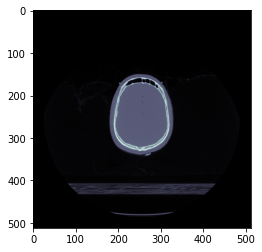

In [4]:
plt.imshow(data[200], cmap=plt.cm.bone)
plt.plot()

In [5]:
verts, faces, normals, values = measure.marching_cubes(data, 700, spacing=(1.0, 1.0, 1.0), step_size=1)

In [6]:
verts = verts / 400
# Requerido cambiar el indexing de los indices a one-indexing
faces = faces + 1

In [7]:
with open(os.path.join(os.path.curdir, 'skull.obj'), 'w') as f:
    for item in verts:
        f.write("v {0} {1} {2}\n".format(item[0], item[1], item[2]))
    for item in normals:
        f.write("vn {0} {1} {2}\n".format(item[0], item[1], item[2]))
    for item in faces:
        f.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0], item[1], item[2]))
    f.close()